# IHLT - LABORATORY 8
Armando Rodriguez Ramos and Yara Yousef

## Import the necessary packages

In [ ]:
!pip install svgling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
import spacy
import svgling
import pandas as pd
from scipy.stats import pearsonr
from nltk.metrics import jaccard_distance
import nltk
from nltk import CFG, ChartParser, BottomUpChartParser, BottomUpLeftCornerChartParser, LeftCornerChartParser

In [ ]:
nlp = spacy.load('en_core_web_sm')

## Define the expanded grammar

**The point of syntactic parsing:**

Syntactic parsing is a way to identify how the words of a sentence are combined, i.e. the syntactic structure of a given sentence. As language is generally hierarhical, sentences can be broken down to phrases which in turn are broken down to the individual words. The syntax of text (or entire language) is the set of rules that govern this hierarchical structure, determining the sequencing of subjects, verbs, verb *phrases*, nouns, noun *phrases*, determiners, prepositional phrases, and so on.

**Our focus:**

The structure we will be using here is a constituent tree, also known as a parse tree. It visualizes the syntax of a given sentence by breaking down the structure into pieces, using "branches" or edges in a nesting configuration. These are created by defining a "grammar", which is here a synonym for syntax, defining the sentence rules. For example, in the grammar defined below, we have that a sentence (S) can be a noun phrase (NP) followed by a verb phrase (VP) OR just a NP. We then define a NP such that it can be a plural noun (NNS) OR an adjective (JJ) followed by a NNS, or two NPs in conjunction (CC). So on and so forth.


This modelling of the rules is known as a context-free grammar (CFG), consisting of four components:

*   Σ: a set of terminal symbols, or the terminal vocabulary, which are the words that will be specified in the rules as belonging to certain constituents. For example, in our grammar below we specify "cats" and "mice" as belonging to NNS, and "big", "small", and "lazy" as belonging to JJ.
*   N: a set of non-terminal symbols representing the different constituents. For example, our set for the grammar defined below is {S, NP, NNS, JJ, CC, VP, V$_t$, PP, IN}, representing Sentence, Noun Phrase, Plural Noun, Adjective, Conjunction, Verb Phrase, Transitive Verb, Propositional Phrase, and Preposition.
*   R: a set of rules, mapping from non-terminals to sequences of one more terminals from the intersection of Σ and N. Simply, these rules are used to define what constituents are contained within a sentence and/or different types of phrases, as well as which terminal symbols belong to which constituents. In other words, they are the rules to follow for the grammar structure.
*   S: a distinguished start symbol from N, which is used as the root vertex to derive the sentence.


Finally, note that here we are using non-probabilistic parsing, which means no weights are applied to the different rules of each constituent category.

In [ ]:
grammar = CFG.fromstring('''
  S  -> NP VP | NP
  NP  -> NNS | JJ NNS | NP CC NP
  NNS -> "cats" | "mice" | NNS CC NNS 
  JJ  -> "big" | "small" | "lazy"
  CC  -> "and" | "or"
  VP  -> VP PP | VP NP | VT
  VT  -> "play"
  PP  -> IN NP
  IN  -> "with"
  ''')

## Define the parsers

Here, we use four NLTK functions to define four different parsers that use different strategies:


1.   ChartParser (generic): For each rule in some strategy, apply that rule to any applicable edges in the chart. Repeat until no new edges are added. The strategy determines what new edges are added to the chart. Here, with the generic parser, the strategy looks at instances 1) what new edges can be added without taking into account existing edges, 2) what new edges can be added according to one particular existing edge, and 3) what new edges can be added according to a particular pair of existing edges.

2.   BottomUpChartParser: Uses a bottom-up strategy. First, it adds all edges allowed by the input, typically an edge between each word ("Bottom-Up Initialization Rule"). Then, until no more edges can be added, it adds a self-loop edge at the left boundary of each complete edge with a grammar production ("Bottom-UP Predict Rule"), and combines any incomplete edges that expect a nonterminal with another complete edge whose left hand side is that same terminal ("The Fundamental Rule").

3.   BottomUpLeftCornerChartParser (similar to ChartParser): Uses a bottom-up strategy but filters out the edges in which no word is subsumed.

4.   LeftCornerChartParser: It combines the top-down and bottom-up approaches of parsing strategies but filters out edges in which no **new** word is subsumed.

\

We have defined two variables for each parser, using different trace values. One of each is set to 0, meaning the tracing output will not be printed, for use when we parse the sentence to draw the tree. The second for each is set to 1, meaning the tracing output will be printed, for when we use the function to chart the parsing of the sentence and evaluate the process.

In [ ]:
parser_c = ChartParser(grammar, trace=1)
parser_bu = BottomUpChartParser(grammar, trace=1)
parser_bu_lc = BottomUpLeftCornerChartParser(grammar, trace=1)
parser_lc = LeftCornerChartParser(grammar, trace=1)

parser_c0 = ChartParser(grammar, trace=0)
parser_bu0 = BottomUpChartParser(grammar, trace=0)
parser_bu_lc0 = BottomUpLeftCornerChartParser(grammar, trace=0)
parser_lc0 = LeftCornerChartParser(grammar, trace=0)

## Check the grammar

First, we check how our defined grammar performs with the sentence "Lazy cats play with mice" given for the exercise, using the generic NLTK ChartParser.

In [ ]:
sentence = ["lazy", "cats", "play", "with", "mice"]

Explored edges:

|.  lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|[-------]       .       .       .       .| [0:1] JJ -> 'lazy' *
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       [-------]       .       .       .| [1:2] NP -> NNS *
|.       [------->       .       .       .| [1:2] NNS -> NNS * CC NNS
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|[--------------->       .       .       .| [0:2] S  -> NP * VP
|[---------------]       .       .       .| [0:2] S  -> NP *
|[--------------->       .       .       .| [0:2] NP -> NP * CC NP
|.       [------->       .       .       .| [1:2] S  -> NP * VP
|.   

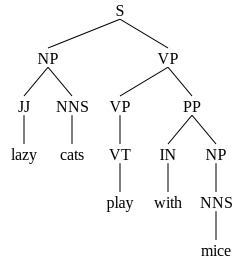

In [ ]:
print("Explored edges:\n")
parsed_sentence = parser_c0.parse(sentence)
parser = parser_c.chart_parse(sentence)
print("\n\nNumber of edges =",parser.num_edges(),"\n\nGenerated tree:\n")
svgling.draw_tree(list(parsed_sentence)[0])

Now, using the same parser, we check that the grammar performs correctly with the original sentence: ['small', 'cats', 'and', 'mice']

Explored edges:

|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         [---------]         .         .| [1:2] NP -> NNS *
|.         [--------->         .         .| [1:2] NNS -> NNS * CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NNS *
|[------------------->         .         .| [0:2] S  -> NP * VP
|[-------------------]         .         .| [0:2] S  -> NP *
|[------------------->         .         .| [0:2] NP -> NP * CC NP
|.         [--------->         .         .| [1:2] S  -> NP * VP
|.         [---------]         .         .| [1:2] S  -> NP *


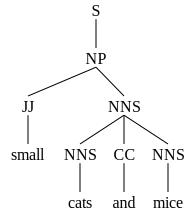

In [ ]:
print("Explored edges:\n")
parsed_sentence = parser_c0.parse(['small', 'cats', 'and', 'mice'])
parser = parser_c.chart_parse(['small', 'cats', 'and', 'mice'])
print("\n\nNumber of edges =",parser.num_edges(),"\n\nGenerated tree:\n")
svgling.draw_tree(list(parsed_sentence)[0])

We can see that this grammar works fine for subsuming these sentences.

## Performing the constituency parsing using other parsers

In this section we wil only show the results of each parser, and then analyze and compare them in the following analysis section.

### BottomUpChartParser

Explored edges:

|.  lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|>       .       .       .       .       .| [0:0] JJ -> * 'lazy'
|[-------]       .       .       .       .| [0:1] JJ -> 'lazy' *
|>       .       .       .       .       .| [0:0] NP -> * JJ NNS
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       >       .       .       .       .| [1:1] NNS -> * 'cats'
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       >       .       .       .       .| [1:1] NP -> * NNS
|.       >       .       .       .       .| [1:1] NNS -> * NNS CC NNS
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|.       [-------]       .       .       .| [1:2] NP -> NNS *
|. 

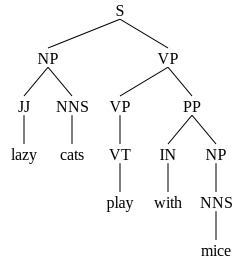

In [ ]:
print("Explored edges:\n")
parsed_sentence = parser_bu0.parse(sentence)
parser = parser_bu.chart_parse(sentence)
print("\n\nNumber of edges =",parser.num_edges(),"\n\nGenerated tree:\n")
svgling.draw_tree(list(parsed_sentence)[0])

### BottomUpLeftCornerChartParser

Explored edges:

|.  lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|[-------]       .       .       .       .| [0:1] JJ -> 'lazy' *
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       [-------]       .       .       .| [1:2] NP -> NNS *
|.       [------->       .       .       .| [1:2] NNS -> NNS * CC NNS
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|[--------------->       .       .       .| [0:2] S  -> NP * VP
|[---------------]       .       .       .| [0:2] S  -> NP *
|[--------------->       .       .       .| [0:2] NP -> NP * CC NP
|.       [------->       .       .       .| [1:2] S  -> NP * VP
|.   

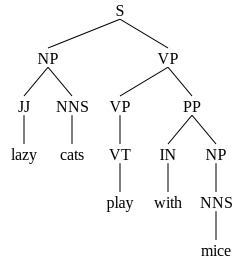

In [ ]:
print("Explored edges:\n")
parsed_sentence = parser_bu_lc0.parse(sentence)
parser = parser_bu_lc.chart_parse(sentence)
print("\n\nNumber of edges =",parser.num_edges(),"\n\nGenerated tree:\n")
svgling.draw_tree(list(parsed_sentence)[0])

### LeftCornerChartParser

Explored edges:

|.  lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|[-------]       .       .       .       .| [0:1] JJ -> 'lazy' *
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       [-------]       .       .       .| [1:2] NP -> NNS *
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|[--------------->       .       .       .| [0:2] S  -> NP * VP
|[---------------]       .       .       .| [0:2] S  -> NP *
|.       [------->       .       .       .| [1:2] S  -> NP * VP
|.       [-------]       .       .       .| [1:2] S  -> NP *
|.       .       [-------]       .       .| [2:3] VT -> 'play' *
|.       .      

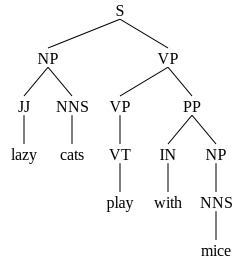

In [ ]:
print("Explored edges:\n")
parsed_sentence = parser_lc0.parse(sentence)
parser = parser_lc.chart_parse(sentence)
print("\n\nNumber of edges =",parser.num_edges(),"\n\nGenerated tree:\n")
svgling.draw_tree(list(parsed_sentence)[0])

## Analysis of the parsers

**Most efficient parser:**

We first note that the results of each parser, i.e. the resulting tree structure, are the same. Consequently, we will determine the efficiency of each parser by just considering the number of explored edges.

The number of explored edges for each method are as follows (note that the generic ChartParser follows the strategy of Bottom-Up Left-Corner):

*   Bottom-Up: 60
*   Bottom-Up Left-Corner: 37
*   Left-Corner: 28

So clearly, the Left-Corner parser is the most efficient one for the example sentence.

\

**Differences in performances:**

Bottom-Up explores 23 edges that Bottom-Up Left-Corner does not, all of which are edges for which the applied rule have any word subsumption. Since these are edges in which no word is subsumed, they are not explored in the Bottom-Up Left-Corner algorithm because it filters it.

Additionally, the Bottom-Up algorithm *and* Bottom-Up Left-Corner algorithm explore 9 edges that the Left-Corner algorithm does not. These are the edges for which all the affected words have already been subsumed, as the Left-Corner algorithm filters out edges in which no **new** words are subsumed.

\

**Final thoughts**

As a final thought, we have to consider that none of the parsers are generally wrong or inefficient; they are different and must be selected and applied appropriately in order to obtain satisfactory results. Moreover, the parsers were only compared using one sentence, and a robust analysis would have to be made in order to extract further conclusions, even if the left-chart parser seems the more obvious option to consider because of its explained efficienccy.

## Optional Exercise: Dependency Parsing

While constituency parsing is used to dissect the structure of a sentence by breaking it down into a hierachy of different types of phrases and words, the goal of dependency parsing is to examine the structure by exploring how the  phrases and words of a sentence syntactically *depend* on each other. This method assumes that each linguistic unit in a sentence is directly related to all the others, and each of these links is considered a dependency.

The idea of the dependency "triplet" is to summarize the overall meaning of a sentence using only three of the words; put in another way, those dependencies should describe the *main* dependencies of the involved words in that sentence. For example, a possible triplet could be the subject, the verb of the sentence, and the direct object.

\

Here, we read in the test set SMTeuroparl files and break the sentences down into their possible dependency triplets. We compare the results of the two sentences of each row to calculate their similarity values, and then compute the final correlation value.

### Read in the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
armandPath = '/content/drive/My Drive/UNIVERSITAT/Master/1-1/IHLT/LabsIHLT/Lab8/Data/'
yaraPath = '/content/drive/My Drive/Labs/IHLT/LabsIHLT/Lab8/Data/'
path = armandPath
dtOriginal = pd.read_csv(path+'STS.input.SMTeuroparl.txt',sep='\t',header=None)
dtOriginal['gs'] = pd.read_csv(path+'STS.gs.SMTeuroparl.txt',sep='\t',header=None)
dtOriginal.head()

0  \
0  The leaders have now been given a new chance a...   
1  Amendment No 7 proposes certain changes in the...   
2  Let me remind you that our allies include ferv...   
3        The vote will take place today at 5.30 p.m.   
4  The fishermen are inactive, tired and disappoi...   

                                                   1    gs  
0  The leaders benefit aujourd' hui of a new luck...  4.50  
1  Amendment No 7 is proposing certain changes in...  5.00  
2  I would like to remind you that among our alli...  4.25  
3                 The vote will take place at 5.30pm  4.50  
4  The fishermen are inactive, tired and disappoi...  5.00

### Define dependency triples function

In [ ]:
def dependencyTriples(sentence):
  doc = nlp(sentence)
  triples = [(token.text)+(str(token.dep_))+(str(token.head)) for token in doc
            if not (token.is_stop or token.pos_=='PUNCT')]

  return set(triples)

#### Apply and compute correlation

In [ ]:
dtLemmaSpaCy = dtOriginal.copy()
dtLemmaSpaCy['dependencyTriples0'] = dtLemmaSpaCy.apply(lambda row: dependencyTriples(row[0]),axis=1)
dtLemmaSpaCy['dependencyTriples1'] = dtLemmaSpaCy.apply(lambda row: dependencyTriples(row[1]),axis=1)
dtLemmaSpaCy['jaccardTriples'] = dtLemmaSpaCy.apply(lambda row: 1-jaccard_distance(row['dependencyTriples0'],row['dependencyTriples1']),axis=1)
dtLemmaSpaCy.head()

0  \
0  The leaders have now been given a new chance a...   
1  Amendment No 7 proposes certain changes in the...   
2  Let me remind you that our allies include ferv...   
3        The vote will take place today at 5.30 p.m.   
4  The fishermen are inactive, tired and disappoi...   

                                                   1    gs  \
0  The leaders benefit aujourd' hui of a new luck...  4.50   
1  Amendment No 7 is proposing certain changes in...  5.00   
2  I would like to remind you that among our alli...  4.25   
3                 The vote will take place at 5.30pm  4.50   
4  The fishermen are inactive, tired and disappoi...  5.00   

                                  dependencyTriples0  \
0  {chancedobjgiven, leadersnsubjpassgiven, hopec...   
1  {AmendmentcompoundNo, referencespobjin, 7nsubj...   
2  {supportersdobjinclude, LetROOTLet, taxpobjof,...   
3  {5.30pobjat, p.m.puncttake, todaynpadvmodtake,...   
4  {fishermennsubjare, disappointedconjtired, tir...   

                                  dependencyTriples1  jaccardTriples  
0  {letconjbenefit, benefitROOTbenefit, leadersns...        0.000000  
1  {proposingROOTproposing, AmendmentcompoundNo, ...        0.400000  
2  {taxpobjof, remindxcomplike, strongacompare, a...        0.090909  
3       {votensubjtake, 5.30pmpobjat, placedobjtake}        0.333333  
4  {fishermennsubjare, disappointedconjtired, tir...        1.000000

An example of the two dependency trees of the two sentences in row index 3 ( jaccard similarity ~= 0.33 )

In [ ]:
doc = nlp(dtLemmaSpaCy[0][3])
spacy.displacy.render(doc,style='dep',jupyter=True)
print(f"\nLength of dependencyTriples0 = {len(dtLemmaSpaCy['dependencyTriples0'][3])}, {dtLemmaSpaCy['dependencyTriples0'][3]}")
doc = nlp(dtLemmaSpaCy[1][3])
spacy.displacy.render(doc,style='dep',jupyter=True)
print(f"\nLength of dependencyTriples1 = {len(dtLemmaSpaCy['dependencyTriples1'][3])}, {dtLemmaSpaCy['dependencyTriples1'][3]}")


Length of dependencyTriples0 = 5, {'5.30pobjat', 'p.m.puncttake', 'todaynpadvmodtake', 'placedobjtake', 'votensubjtake'}



Length of dependencyTriples1 = 3, {'votensubjtake', '5.30pmpobjat', 'placedobjtake'}


We can see here that, as it should be, the root of both trees is the verb "take". The noun "vote" is the subject, and the noun "place" is the direct object. However, for the second sentence where "5:30pm" is considered one word, this word (counted as NUM) is the prepositional object. In the second sentence, where "5:30" and "p.m." are considered separate words (counted as NUM and ADV respectively), "5:30" is the prepositional object and there is a new relation of punctuation for "p.m.". 

Hence, even though they convey the same meaning, they are not considered as such during the comparison. Continuing, in the first sentence there is an additional token thanks to the noun "today", further distancing the similarity of the possible triplets of the two sentences.

##### Calculating the Pearson correlation

In [ ]:
corrLemmaSpaCy = pearsonr(dtLemmaSpaCy['gs'], dtLemmaSpaCy['jaccardTriples'])[0]*100
print("Pearson correlation coefficient with SpaCy lemmatizer =", round(corrLemmaSpaCy,3), "%")

Pearson correlation coefficient with SpaCy lemmatizer = 40.947 %


### Analysis and Conclusions

Clearly, we don't get a high number for the Pearson correlation, which tells us that comparison using dependency triplets is not a very effective measure, or at least not on its own.

It is possible some more pre-processing could yield a better similarity value for this method; for example, issues such as the discrepancy in the triplets between "5:30pm" and "5:30" + "p.m." could be lessened using the name entity merging employed in Lab 7. Hence, we are quite sure that the usage of the name entities combined with the dependency triples would lead to better results as the important "packs" of words will have a better dependency metric all across the dataset.